In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.collab import *
from fastai.tabular.all import *

In [2]:
# A good way to describe collaborative learning is with an example:
# Suppose that I'm looking for Netflix to recommend a movie, while it may be possible to suggest movies
# Based on what I've seen, a more effective approach would be to look at what others have seen and suggest
# a film based on that data
# That's collaborative Learning in a nutshell, and we see it everywhere from online ads to item suggestions
# as well as other uses where collaboration of different types of data comes into play

# For this example, well be working with a dataset comprising of movie reviews

# Here we will be using a similar concept to filters in convolutional networks, but since we are not 
# working with images, we can't apply our standard R, G, and B filters
# Instead we will be choosing a set of weights (n=5) that individually are assigned to each user and movie
# and will use a powerful tool availbale in pytorch called 'embedding' which will allows us to index
# and work with these weights accodingly

path = untar_data(URLs.ML_100k)

In [3]:
path.ls().sorted()

(#23) [Path('/home/slabban/.fastai/data/ml-100k/README'),Path('/home/slabban/.fastai/data/ml-100k/allbut.pl'),Path('/home/slabban/.fastai/data/ml-100k/mku.sh'),Path('/home/slabban/.fastai/data/ml-100k/u.data'),Path('/home/slabban/.fastai/data/ml-100k/u.genre'),Path('/home/slabban/.fastai/data/ml-100k/u.info'),Path('/home/slabban/.fastai/data/ml-100k/u.item'),Path('/home/slabban/.fastai/data/ml-100k/u.occupation'),Path('/home/slabban/.fastai/data/ml-100k/u.user'),Path('/home/slabban/.fastai/data/ml-100k/u1.base')...]

In [4]:
# Though not visually obvious, there are empty in this dataset for users who have not reviewed
# (and hence, not watched) certain films, the idea is to fill those gaps with a probability that the
# user will want to watch the certain movie based on other users (collaboration of data)

ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
# The guiding principle behind this process is shown below, we essentially take the dot product
# of the factors as they are scaled between 0 and 1

# The dot product is mathematically explained as the product of two matrices (Not Matrix Multiplication!)
# and the sum of the result

#  As an exampled, lets take the following as the three factors weight against a user's general preferences:
# science-fiction, action, and old movies

last_skywalker = np.array([0.98,0.9,-0.9])
user1 = np.array([0.9,0.8,-0.6])
(user1*last_skywalker).sum()

2.1420000000000003

In [6]:
# Our user1 clearly likes action, lets compare this with a movie like casablanca.. user1 probably
# wont want to watch that

casablanca = np.array([-0.99,-0.3,0.8])

(user1*casablanca).sum()

-1.611

In [7]:
# Lets create our Dataloader
# WE can make things more interesting by including the movie names

movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [8]:
# Using pandas' cool functionality, we can join the two dataframs for movies and ratings

ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [9]:
CollabDataLoaders.from_df??

In [10]:
# Cool enought, we can build the Dataloaders directly from this data frame

dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


In [11]:
dls.classes

{'user': ['#na#', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

In [12]:
# Again we see the power of one-hot encoding to index into our 5 arbitrarily chosen factors/weights

n_users  = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [13]:
user_factors[3]

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

In [14]:
# The lines below show the long process of achieving the same result we got by indexing into the 
# arrays above. However, taking the multiplication route is costly to our memory and time

# it indexes into a vector using an integer, but has its derivative calculated 
# in such a way that it is identical to what it would have been if it had done a
# matrix multiplication with a one-hot-encoded vector. This is called an embedding.


one_hot_3 = one_hot(3, n_users).float()
user_factors.t() @ one_hot_3

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

In [15]:
# Now we take a look at the core fundamental concept of Pytorch when it comes to creating a model
# This is a class called 'Module', we will create a class that inherits the Module Class

class DotProduct (Module):
        def __init__(self, n_users, n_movies, n_factors):
            self.user_factors = Embedding(n_users, n_factors)
            self.movie_factors = Embedding(n_movies, n_factors)
        
        def forward(self, x):
            users = self.user_factors(x[:,0])
            movies = self.movie_factors(x[:,1])
            return (users * movies).sum(dim=1)

In [16]:
# Note that the input of the model is a tensor of shape batch_size x 2, 
# where the first column (x[:, 0]) contains the user IDs and the second column (x[:, 1]) 
# contains the movie IDs

x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

In [17]:
# We now instantiate our model and create a learner, specifying our Mean Squared Error as our loss function

model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

In [18]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.344786,1.279100,00:06
1,1.093331,1.109981,00:06
2,0.958258,0.990199,00:06
3,0.814234,0.894916,00:06
4,0.780714,0.882022,00:06


In [19]:
# One way we can imporove the is to add the sigmoid_range to define a range for our values
# The range below is based on empirical discoveries

class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [20]:
# We see that we've made our model more efficient, but there is a pitfall where our loss begins
# to increase at the last epoch

model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.986799,1.005294,00:06
1,0.878134,0.918898,00:06
2,0.675850,0.875467,00:07
3,0.483372,0.877939,00:06
4,0.378927,0.881887,00:07


In [21]:
# So we have a reasonable model, but we did not account for the possibility of some factors
# such as the movie being bad

class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [22]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.938634,0.952516,00:08
1,0.846664,0.865633,00:07
2,0.608090,0.865127,00:07
3,0.413482,0.887318,00:07
4,0.286971,0.894876,00:07


In [23]:
# Here we see use another fundamental concept call L2 Regularization the TLDR is that is penalizes for
# large weights by adding  the squared sum of the weights to the loss function, this is meant to 
# combat overfitting, which we can see occuring in the trained model above, reflected by the decreasing 
# training_loss and increasing validation_loss

# We see that the model performs better and that is reflected in the losses as seen below

# Here's a video that explains the concpet of L2 Regularization well:
# https://www.youtube.com/watch?v=iuJgyiS7BKM&list=PLZbbT5o_s2xq7LwI2y8_QtvuXZedL6tQU&index=35

model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.932776,0.961672,00:08
1,0.888625,0.882614,00:07
2,0.771066,0.832743,00:08
3,0.599807,0.822374,00:07
4,0.504981,0.822528,00:07


In [24]:
# To take a look behind the scenes, the module class uses nn.parameters to assign weights
# which are tracked using the requires_grad parameter that is used for SGD, which we saw earlier

def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [25]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [26]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.923278,0.947485,00:08
1,0.867184,0.878225,00:08
2,0.722469,0.835867,00:08
3,0.589465,0.824819,00:08
4,0.477854,0.824497,00:08


In [27]:
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Mortal Kombat: Annihilation (1997)',
 'Robocop 3 (1993)',
 "Joe's Apartment (1996)"]

In [28]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'L.A. Confidential (1997)',
 "Schindler's List (1993)"]

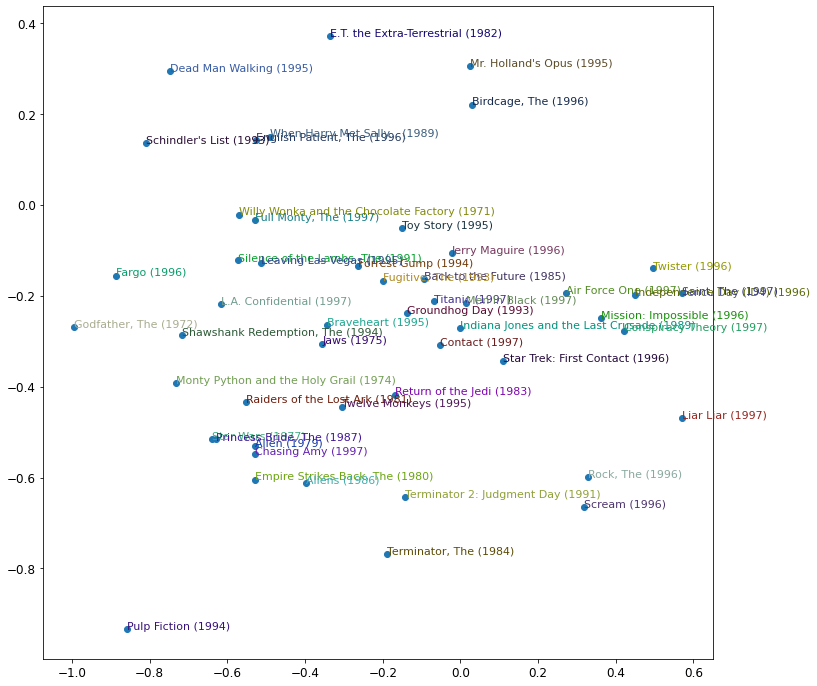

In [29]:
# Looking at the graph below we can see that the model has in face learnt to categorize these
# movies, for example the left side tend to be more cult-classic-y and on the right we have 
# some more action packed films

# Personally collaborative learning has been on of the more abstract concepts, but its
# ability to make sense of the data through only knowing the users and movies is almost magical


#hide_input
#id img_pca_movie
#caption Representation of movies based on two strongest PCA components
#alt Representation of movies based on two strongest PCA components
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

In [30]:
# Leveraging the power of fastai, we can do all the above with our dataloaders using just one line

learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [31]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.939655,0.957980,00:08
1,0.841034,0.876615,00:08
2,0.722659,0.835347,00:08
3,0.600329,0.821595,00:07
4,0.477595,0.822365,00:07


In [32]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [33]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['L.A. Confidential (1997)',
 'Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'Rear Window (1954)']

In [34]:
# Another intersting thing we can do is leverage the pythogoras theorem to find a similar movie
# through calculating the distance between embedding vectors

movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Wedding Gift, The (1994)'

In [35]:
# The approach of taking the dot product of the factors is called Probabilistic Matrix Factorization (PMF)
# and is a popular approach among many real-world recommendation systems

# Another approach that works will is with deep learning. For this approach, we will have to take the
# results of the embedding lookup and the activations together rather than taking the dot product

# Since we'll be concatenating the embeddings, rather than taking their dot product, the two embedding matrices 
# can have different sizes (i.e., different numbers of latent factors). fastai has a function 'get_emb_sz' 
# that returns recommended sizes for embedding matrices for your data

embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [36]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [37]:
model = CollabNN(*embs)

In [38]:

learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.942990,0.949061,00:11
1,0.914267,0.898214,00:08
2,0.848322,0.882869,00:08
3,0.814815,0.874680,00:08
4,0.764386,0.877850,00:08


In [40]:
# fastai's collab learner can also perform this action if the parameter use_nn = true in the collab_learner call
# This also calls get_emb_sz behind the scenes

# Although this approach gives us a slightly sorse model, it is powerful in that it provides us with
# the ability to include more user and movie information, which is a great segue to the tabular data topic

learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.004130,0.995062,00:10
1,0.877428,0.926584,00:09
2,0.886536,0.902054,00:09
3,0.819502,0.871534,00:09
4,0.796938,0.870357,00:09


In [42]:
# learn.model is an object of type EmbeddingNN that inehrits from the TabularModel parent

learn.model??